In [18]:
import gensim
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
import torch
import torch.nn as nn
import torch.nn.functional as F

# Word2Vec Tutorial

This notebook demonstrates how to use Word2Vec for word embedding generation, visualization, and analysis.

## Introduction
Word2Vec is a neural network-based model that converts words into dense vectors of fixed size, capturing semantic relationships between words. These vectors are used in various NLP tasks, such as text classification, sentiment analysis, and more.

### Key Concepts
- **Continuous Bag of Words (CBOW):** Predicts a word based on its context.
- **Skip-Gram:** Predicts the context based on a given word.

Both methods aim to create word embeddings that preserve semantic relationships.

### Step 1: Prepare the Data

In [19]:
corpus = [
    "machnine learning models are powerful",
    "word embeddings like word2vec are useful",
    "deep learning uses   networks",
    "neural networks are a key component of deep learning",
    "word2vec captures word relationships in dense vectors"
]

In [20]:
tokenized_corpus = [sentence.lower().split() for sentence in corpus]

In [21]:
tokenized_corpus

[['machnine', 'learning', 'models', 'are', 'powerful'],
 ['word', 'embeddings', 'like', 'word2vec', 'are', 'useful'],
 ['deep', 'learning', 'uses', 'networks'],
 ['neural',
  'networks',
  'are',
  'a',
  'key',
  'component',
  'of',
  'deep',
  'learning'],
 ['word2vec', 'captures', 'word', 'relationships', 'in', 'dense', 'vectors']]

### Step 2: Train a Word2Vec Model

In [22]:
model = Word2Vec(
    sentences=tokenized_corpus,
    vector_size=100,
    window=3,
    min_count=1,
    sg=1,
    epochs=100
)

### Step 3: Visualize Word Embeddings

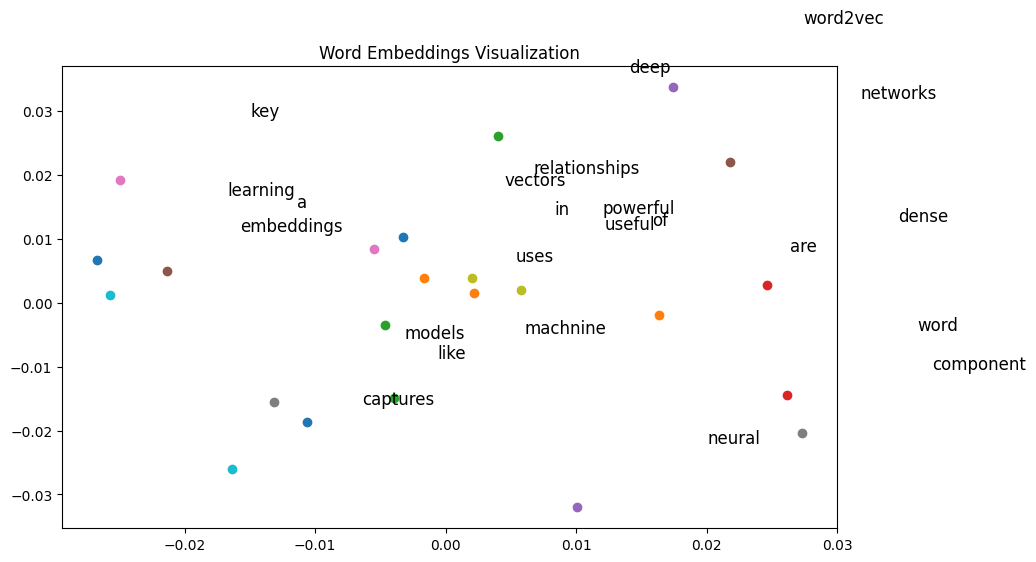

In [23]:
words = list(model.wv.key_to_index.keys())
word_vectors = model.wv[words]

pca = PCA(n_components=2)
word_vectors_2d = pca.fit_transform(word_vectors)

plt.figure(figsize=(10, 6))
for i, word in enumerate(words):
    plt.scatter(word_vectors_2d[i, 0], word_vectors_2d[i, 1])
    plt.text(word_vectors_2d[i, 0] + 0.01, word_vectors_2d[i, 1] + 0.01, word, fontsize=12)
plt.title("Word Embeddings Visualization")
plt.show()

### Step 4: Analyze Word Relationships

In [24]:
print("Most similar to 'deep':", model.wv.most_similar('deep'))
print("Similarity between 'deep' and 'learning':", model.wv.similarity('deep', 'learning'))

Most similar to 'deep': [('powerful', 0.20509175956249237), ('useful', 0.17881599068641663), ('word2vec', 0.1783902794122696), ('of', 0.1585485190153122), ('relationships', 0.15554459393024445), ('vectors', 0.15340809524059296), ('networks', 0.07039446383714676), ('uses', 0.049122154712677), ('component', 0.009663776494562626), ('models', 0.004639407619833946)]
Similarity between 'deep' and 'learning': -0.039011378


### Step 5: Save and Load the Model

In [25]:
# model.save("word2vec.model")

# loaded_model = Word2Vec.load("word2vec.model")

### Conclusion
Word2Vec is a powerful tool for learning word embeddings. It captures semantic meanings and relationships, enabling its use in various NLP tasks. This notebook demonstrates how to train, visualize, and analyze word embeddings using Word2Vec.

In [26]:
class Word2VecCBOW(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(Word2VecCBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        # Initialize linear layer to map embeddings to vocabulary space
        self.linear = nn.Linear(embedding_dim, vocab_size)
    
    def forward(self, context_idxs):
        # Look up embeddings for context words and calculate their mean
        embeddings = self.embeddings(context_idxs).mean(dim=0)
        # Apply the linear layer to map mean embeddings to vocabulary space
        # we're using the context, to predict all words in the vocabulary. The model will try to learn to give the highest 
        # probability to the word we want to predict.
        output = self.linear(embeddings)
        return output  # Return raw scores (logits)

In [60]:
train_word2vec_cbow(model, tokenized_corpus, word_to_idx, idx_to_word, epochs=10, learning_rate=0.01, window_size=1)

item 17
learning
[tensor(18), tensor(22)]
[tensor(17), tensor(14)]
[tensor(22), tensor(12)]
item 14
are
item 0
embeddings
[tensor(20), tensor(19)]
[tensor(0), tensor(5)]
[tensor(19), tensor(14)]
[tensor(5), tensor(3)]
item 14
are
item 17
learning
[tensor(16), tensor(13)]
[tensor(17), tensor(21)]
item 13
uses
item 21
networks
[tensor(2), tensor(14)]
[tensor(21), tensor(1)]
[tensor(14), tensor(7)]
[tensor(1), tensor(6)]
[tensor(7), tensor(8)]
[tensor(6), tensor(16)]
[tensor(8), tensor(17)]
item 16
deep
item 10
captures
[tensor(5), tensor(20)]
[tensor(10), tensor(9)]
[tensor(20), tensor(11)]
[tensor(9), tensor(15)]
[tensor(11), tensor(4)]
item 15
dense
item 17
learning
[tensor(18), tensor(22)]
[tensor(17), tensor(14)]
[tensor(22), tensor(12)]
item 14
are
item 0
embeddings
[tensor(20), tensor(19)]
[tensor(0), tensor(5)]
[tensor(19), tensor(14)]
[tensor(5), tensor(3)]
item 14
are
item 17
learning
[tensor(16), tensor(13)]
[tensor(17), tensor(21)]
item 13
uses
item 21
networks
[tensor(2), ten

In [56]:
tokenized_corpus[0]

['machnine', 'learning', 'models', 'are', 'powerful']

In [65]:
idx_to_word[14]

'are'

In [81]:
def train_word2vec_cbow(model, tokenized_corpus, word_to_idx, idx_to_word, epochs=10, learning_rate=0.01, window_size=1):
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    loss_function = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        total_loss = 0  
        for sentence in tokenized_corpus:
            # Convert the sentence into indices based on word_to_idx mapping
            sentence_tensor = torch.tensor([word_to_idx[word] for word in sentence], dtype=torch.long)
            
            for target_idx in range(len(sentence)):
                # idxs from 0 to the len of the sentence -1
                # Define the range of context words around the target word
                # when window_size is 1, we get one word on the left and one word on the right
                context_range = range(max(0, target_idx - window_size), min(len(sentence), target_idx + window_size + 1))
                # Collect indices of context words, excluding the target word
                context_idxs = [sentence_tensor[i] for i in context_range if i != target_idx]
  
                # if len(context_idxs) == 1:
                #     item = context_idxs[0].item()
                #     print('item', item)
                #     print(idx_to_word[item])
                # else:
                #     print(context_idxs)

                        
                
                if not context_idxs:
                    continue  # Skip if there are no valid context words
                
                # Convert context indices to tensor
                context_tensor = torch.tensor(context_idxs, dtype=torch.long)
                # Get the target word index safely
                target_tensor = sentence_tensor[target_idx].clone().detach()
                
                optimizer.zero_grad()
                
                logits = model(context_tensor)
                
                loss = loss_function(logits.view(1, -1), target_tensor.view(-1))
                total_loss += loss.item()  # Accumulate loss
                
                loss.backward()
                optimizer.step()

        
        # Print total loss for the epoch
        if epoch % 10 == 0: print(f"Epoch {epoch + 1}, Loss: {total_loss}")

In [82]:
corpus = [
    "apples and bananas are popular fruits",
    "oranges and mangoes are sweet and tasty",
    "computers process data and execute instructions",
    "laptops and desktops are types of computers",
    "fruits are healthy and rich in vitamins",
    "modern computers are fast and efficient",
    "bananas and mangoes are tropical fruits",
    "computers use binary code to represent information",
    "apples and oranges are common fruits in the market",
    "desktops are more powerful than most laptops"
]

In [83]:
# Tokenize corpus into lists of words
tokenized_corpus = [sentence.lower().split() for sentence in corpus]
# Create vocabulary and mappings
vocab = set(word for sentence in tokenized_corpus for word in sentence)
word_to_idx = {word: idx for idx, word in enumerate(vocab)}
idx_to_word = {idx: word for word, idx in word_to_idx.items()}

In [93]:
# Initialize CBOW model
embedding_dim = 10  # Define size of word embeddings
model = Word2VecCBOW(len(vocab), embedding_dim)

In [102]:
train_word2vec_cbow(model, tokenized_corpus, word_to_idx, idx_to_word, epochs=1000, learning_rate=0.05, window_size=1)

Epoch 1, Loss: 254.42597651481628
Epoch 11, Loss: 128.78932258486748
Epoch 21, Loss: 86.96637108176947
Epoch 31, Loss: 65.79822026565671
Epoch 41, Loss: 55.5541403349489
Epoch 51, Loss: 50.356159303337336
Epoch 61, Loss: 47.37624829309061
Epoch 71, Loss: 45.45629781612661
Epoch 81, Loss: 44.107659003464505
Epoch 91, Loss: 43.09955845493823
Epoch 101, Loss: 42.31124584993813
Epoch 111, Loss: 41.67393708170857
Epoch 121, Loss: 41.14562462712638
Epoch 131, Loss: 40.69905692478642
Epoch 141, Loss: 40.31569761666469
Epoch 151, Loss: 39.98240884911502
Epoch 161, Loss: 39.68956918746699
Epoch 171, Loss: 39.42996126061189
Epoch 181, Loss: 39.198003982397495
Epoch 191, Loss: 38.989350230258424
Epoch 201, Loss: 38.8005276308395
Epoch 211, Loss: 38.62872898047499
Epoch 221, Loss: 38.47166881343583
Epoch 231, Loss: 38.327460052256356
Epoch 241, Loss: 38.19451738613134
Epoch 251, Loss: 38.07153977868438
Epoch 261, Loss: 37.957391223317245
Epoch 271, Loss: 37.85113080406154
Epoch 281, Loss: 37.75192

In [94]:
word = "apples"
word_idx = torch.tensor([word_to_idx[word]], dtype=torch.long)
embedding = model.embeddings(word_idx).detach().numpy()
print(f"Embedding for '{word}': {embedding}")

Embedding for 'apples': [[ 0.610962    0.17692706  0.7036409   0.34974256 -0.44162098  0.6641996
   0.5258699  -1.3626604   0.56453204 -0.11841733]]


In [ ]:
# train_word2vec_cbow(model, tokenized_corpus, word_to_idx, idx_to_word, epochs=10, learning_rate=0.01, window_size=1)

In [104]:
def cosine_similarity(vec1, vec2):
    dot_product = torch.dot(vec1, vec2)
    magnitude1 = torch.norm(vec1)
    magnitude2 = torch.norm(vec2)
    
    return dot_product / (magnitude1 * magnitude2)

In [105]:
def find_similarity(word1, word2):
    word1_idx = torch.tensor([word_to_idx[word1]], dtype=torch.long)
    embds1 = model.embeddings(word1_idx).detach()

    word2_idx = torch.tensor([word_to_idx[word2]], dtype=torch.long)
    embds2 = model.embeddings(word2_idx).detach()

    return cosine_similarity(embds1.squeeze(), embds2.squeeze())

In [99]:
find_similarity('oranges', 'laptops')

tensor(0.1217)

In [100]:
find_similarity('oranges', 'bananas')

tensor(0.0471)

In [101]:
find_similarity('apples', 'bananas')

tensor(-0.1637)

In [106]:
find_similarity('oranges', 'laptops')

tensor(0.1153)

In [107]:
find_similarity('oranges', 'bananas')

tensor(0.4395)